# Full Cross-Validation and Final Training Evaluation Workflow

This repository contains a Jupyter Notebook that implements a complete workflow for training, evaluating, and visualizing the performance of a **Graph Attention Network (GAT)** for graph-based regression or classification tasks. The workflow includes cross-validation, hyperparameter tuning, ensemble averaging, and final model evaluation.

---

## 📋 Workflow Overview

### 1. **Imports and Setup**
- Load essential libraries: PyTorch, PyTorch Geometric, scikit-learn, and matplotlib.
- Configure plotting and file management tools.

### 2. **Task and Reproducibility Setup**
- Define the task: `classification` or `regression`.
- Set a fixed random seed for reproducibility.
- Specify class names (for classification) and configure result directories.

### 3. **Model Definition**
- Define an **GAT Model**
- The model processes node and edge features and outputs predictions.

### 4. **Evaluation Helper Function**
- Implements an `evaluate(model, loader)` function to compute predictions and ground truths for a given dataset.

### 5. **Input Dimensions and Device Setup**
- Automatically determine input feature dimensions from the dataset.
- Detect and assign the appropriate device (CPU or GPU).

### 6. **Hyperparameter Tuning**
- Perform a grid search over hyperparameters:
    - Hidden dimensions
    - Dropout rates
    - Learning rates
- Train and validate the model across multiple folds, logging metrics for each configuration.

### 7. **Cross-Validation Training**
- Train the model across 10 folds using pre-split datasets.
- Log metrics for each fold:
    - **Regression**: MAE, MSE, RMSE, R²
    - **Classification**: Accuracy, Precision, Recall, F1, AUC-ROC
- Save fold-wise results to a CSV file.

### 8. **Ensemble Averaging**
- Combine predictions from all fold models using ensemble averaging.
- Evaluate the ensemble on the test set and compute metrics.

### 9. **Final Model Training**
- Merge all training and validation folds into a single dataset.
- Reserve a small validation split for early stopping.
- Train the final model with:
    - Early stopping (based on validation loss)
    - Learning rate scheduler
    - Model checkpointing (saves the best model)
- Evaluate the final model on the test set.

### 10. **Visualization**
- Generate plots for:
    - Cross-validation metrics (e.g., MAE, MSE, RMSE, R² per fold)
    - Ensemble predictions vs. true values
    - Final model predictions vs. true values
- Save plots and metrics to the results directory.

---

## 📊 Outputs
1. **Cross-Validation Results**:
     - Fold-wise metrics saved to `crossval_summary.csv`.
     - Bar charts for fold-wise metrics.
     - Mean ± standard deviation summary.

2. **Ensemble Results**:
     - Ensemble predictions and metrics.
     - Scatter plot of ensemble predictions vs. true values.

3. **Final Model Results**:
     - Final model predictions and metrics.
     - Scatter plot of final model predictions vs. true values.
     - Saved final model weights.

---

## 🚀 How to Run
1. Ensure all dependencies are installed:
     - PyTorch, PyTorch Geometric, scikit-learn, matplotlib, numpy, pandas.
2. Prepare your dataset in the required format (node features, edge features, labels).
3. Configure the task (`classification` or `regression`) and hyperparameters in the notebook.
4. Execute the notebook step-by-step to train, evaluate, and visualize the model.

---



## 1. Imports and Setup

In [33]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

## 2. Task and Reproducibility Setup

In [15]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#task = "classification"  # or "regression"
task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../4_train_test_split/10fold_cv/{task}/"
results_dir = f"GAT_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3. Define GAT model

In [3]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.lin = Linear(hidden_channels * heads, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Aggregate node features to graph level
        return self.lin(x)

## 4. Evaluation Helper Function

In [4]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [6]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
output_dim = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/1340473836.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_data = torch.load(os.path.join(base_pa

## 6: Hyperparameter Tuning

In [24]:
# Hyperparameter grids
hidden_dims = [64, 128, 256]
dropouts = [0.0, 0.2, 0.4]
lrs = [1e-3, 5e-4, 1e-4]

# hidden_dims = [64]
# dropouts = [0.4]
# lrs = [1e-3]

results = []
print("Starting hyperparameter sweep over hidden_dim, dropout, and learning rate")
for hd in hidden_dims:
    for dp in dropouts:
        for lr in lrs:
            print(f"Config: hidden_dim={hd}, dropout={dp}, lr={lr}")
            fold_metrics = []
            for fold in range(10):
                # Load fold data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

                # Initialize model and optimizer
                model = GAT(in_channels=input_dim, hidden_channels=hd,
                            out_channels=output_dim, heads=1, dropout=dp).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Data loaders
                train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
                val_loader   = DataLoader(val_data,   batch_size=32)

                # Training loop
                for epoch in range(1, 51):
                    model.train()
                    for batch in train_loader:
                        batch = batch.to(device)
                        optimizer.zero_grad()
                        out = model(batch)
                        loss = F.mse_loss(out.squeeze(), batch.y)
                        loss.backward()
                        optimizer.step()

                # Validation
                preds, trues = evaluate(model, val_loader)
                y_true = trues.numpy()
                y_pred = preds.squeeze().numpy()
                r2 = r2_score(y_true, y_pred)
                fold_metrics.append(r2)

            # Record mean and std
            mean_r2 = np.mean(fold_metrics)
            std_r2  = np.std(fold_metrics)
            results.append((hd, dp, lr, mean_r2, std_r2))
            print(f"📊 R²: {mean_r2:.4f} ± {std_r2:.4f}")

# Compile results into DataFrame
sweep_df = pd.DataFrame(results,
                        columns=["hidden_dim", "dropout", "learning_rate", "mean_r2", "std_r2"])
# Display sorted by best performance
display(sweep_df.sort_values("mean_r2", ascending=False))
cv_df = pd.DataFrame(fold_metrics)


Starting hyperparameter sweep over hidden_dim, dropout, and learning rate
Config: hidden_dim=64, dropout=0.0, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: 0.2440 ± 0.1679
Config: hidden_dim=64, dropout=0.0, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: 0.2080 ± 0.1210
Config: hidden_dim=64, dropout=0.0, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.3532 ± 0.2388
Config: hidden_dim=64, dropout=0.2, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.3150 ± 0.5130
Config: hidden_dim=64, dropout=0.2, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.4611 ± 0.3913
Config: hidden_dim=64, dropout=0.2, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -1.2707 ± 0.7678
Config: hidden_dim=64, dropout=0.4, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.5693 ± 0.6447
Config: hidden_dim=64, dropout=0.4, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -1.1577 ± 1.6831
Config: hidden_dim=64, dropout=0.4, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -3.6436 ± 1.5084
Config: hidden_dim=128, dropout=0.0, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: 0.2793 ± 0.1845
Config: hidden_dim=128, dropout=0.0, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: 0.2528 ± 0.1322
Config: hidden_dim=128, dropout=0.0, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.0928 ± 0.2047
Config: hidden_dim=128, dropout=0.2, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.6128 ± 0.8344
Config: hidden_dim=128, dropout=0.2, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.5442 ± 0.6681
Config: hidden_dim=128, dropout=0.2, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.9381 ± 0.5678
Config: hidden_dim=128, dropout=0.4, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.7894 ± 0.6706
Config: hidden_dim=128, dropout=0.4, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.6023 ± 0.8016
Config: hidden_dim=128, dropout=0.4, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -3.3725 ± 1.6636
Config: hidden_dim=256, dropout=0.0, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: 0.2721 ± 0.1413
Config: hidden_dim=256, dropout=0.0, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: 0.2201 ± 0.2020
Config: hidden_dim=256, dropout=0.0, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: 0.1077 ± 0.1846
Config: hidden_dim=256, dropout=0.2, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -1.0573 ± 1.4423
Config: hidden_dim=256, dropout=0.2, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.3811 ± 0.4847
Config: hidden_dim=256, dropout=0.2, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.7380 ± 0.6109
Config: hidden_dim=256, dropout=0.4, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -1.5352 ± 1.4647
Config: hidden_dim=256, dropout=0.4, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.7063 ± 0.7975
Config: hidden_dim=256, dropout=0.4, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/2781885572.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -1.8049 ± 1.3186


,hidden_dim,dropout,learning_rate,mean_r2,std_r2
9,128,0.0,0.0010,0.279303,0.184492
18,256,0.0,0.0010,0.272081,0.141304
10,128,0.0,0.0005,0.252845,0.132227
0,64,0.0,0.0010,0.243987,0.167946
19,256,0.0,0.0005,0.220064,0.201960
1,64,0.0,0.0005,0.208035,0.120979
20,256,0.0,0.0001,0.107665,0.184640
11,128,0.0,0.0001,-0.092850,0.204748
3,64,0.2,0.0010,-0.315024,0.512992
2,64,0.0,0.0001,-0.353155,0.238805


## select best hyperparameters

In [26]:

# %% to change later
best_heads = 1
best_hidden_dim = 128
best_dropout = 0.0
best_lr = 0.001

## 7: Retrain All Folds with Best Hyperparameters

In [27]:

# %%
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import pandas as pd

fold_metrics = []

for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10 with best hyperparameters")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = GAT(in_channels=input_dim, hidden_channels=best_hidden_dim,
            out_channels=output_dim, heads=best_heads, dropout=best_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf')
    patience = 0

    # Training loop with early stopping
    for epoch in range(1, 301):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = (F.cross_entropy(out, batch.y.long())
                    if task=="classification"
                    else F.mse_loss(out.squeeze(), batch.y))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate on validation
        preds, targets = evaluate(model, val_loader)
        val_loss = (F.cross_entropy(preds, targets.long()).item()
                    if task=="classification"
                    else F.mse_loss(preds.squeeze(), targets).item())

        print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            torch.save(model.state_dict(),
                       os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience += 1
            if patience >= 10:
                print("⏹️ Early stopping")
                break

    # --- After training this fold, compute metrics on its validation set ---
    preds_np = preds.squeeze().cpu().numpy()
    trues_np = targets.cpu().numpy()

    if task == "classification":
        from sklearn.metrics import (
            accuracy_score,
            precision_recall_fscore_support,
            roc_auc_score
        )
        y_true = trues_np.astype(int)
        y_probs = F.softmax(preds, dim=1).cpu().numpy()
        y_pred  = preds.argmax(dim=1).cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", zero_division=0)
        auc = roc_auc_score(
            label_binarize(y_true, classes=np.arange(num_classes)),
            y_probs, multi_class="ovr")

        fold_metrics.append({
            "fold": fold+1,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc_roc": auc
        })
    else:  # regression
        mae  = mean_absolute_error(trues_np, preds_np)
        mse  = mean_squared_error(trues_np, preds_np)
        rmse = np.sqrt(mse)
        r2   = r2_score(trues_np, preds_np)

        fold_metrics.append({
            "fold": fold+1,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "r2": r2
        })

# --- Save the cross-validation summary ---
cv_df = pd.DataFrame(fold_metrics)
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df.to_csv(cv_path, index=False)
print(f"✅ Saved cross‑validation summary to {cv_path}")



🔁 Retraining Fold 1/10 with best hyperparameters


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 30.5717 | Val Loss: 8.7466
Epoch 002 | Train Loss: 3.8437 | Val Loss: 4.5891
Epoch 003 | Train Loss: 2.7648 | Val Loss: 2.2133
Epoch 004 | Train Loss: 1.9122 | Val Loss: 2.1792
Epoch 005 | Train Loss: 1.7325 | Val Loss: 2.1141
Epoch 006 | Train Loss: 1.6945 | Val Loss: 2.0025
Epoch 007 | Train Loss: 1.6220 | Val Loss: 1.9557
Epoch 008 | Train Loss: 1.5417 | Val Loss: 1.8585
Epoch 009 | Train Loss: 1.5804 | Val Loss: 1.8032
Epoch 010 | Train Loss: 1.4230 | Val Loss: 1.6774
Epoch 011 | Train Loss: 1.3759 | Val Loss: 1.6479
Epoch 012 | Train Loss: 1.2847 | Val Loss: 1.4975
Epoch 013 | Train Loss: 1.2231 | Val Loss: 1.3799
Epoch 014 | Train Loss: 1.2079 | Val Loss: 1.3342
Epoch 015 | Train Loss: 1.1376 | Val Loss: 1.2296
Epoch 016 | Train Loss: 1.1613 | Val Loss: 1.3959
Epoch 017 | Train Loss: 1.0552 | Val Loss: 1.1356
Epoch 018 | Train Loss: 1.0468 | Val Loss: 1.0582
Epoch 019 | Train Loss: 1.0707 | Val Loss: 1.0342
Epoch 020 | Train Loss: 1.0173 | Val Loss: 1.0867

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 31.6607 | Val Loss: 14.2013
Epoch 002 | Train Loss: 6.0375 | Val Loss: 2.4601
Epoch 003 | Train Loss: 1.7453 | Val Loss: 1.2020
Epoch 004 | Train Loss: 1.1492 | Val Loss: 1.1304
Epoch 005 | Train Loss: 1.1421 | Val Loss: 1.2035
Epoch 006 | Train Loss: 1.1485 | Val Loss: 1.1268
Epoch 007 | Train Loss: 1.1551 | Val Loss: 1.1309
Epoch 008 | Train Loss: 1.1327 | Val Loss: 1.1374
Epoch 009 | Train Loss: 1.0803 | Val Loss: 1.1316
Epoch 010 | Train Loss: 1.0986 | Val Loss: 1.1167
Epoch 011 | Train Loss: 1.0590 | Val Loss: 1.0942
Epoch 012 | Train Loss: 1.0957 | Val Loss: 1.1099
Epoch 013 | Train Loss: 1.0528 | Val Loss: 1.0803
Epoch 014 | Train Loss: 1.0644 | Val Loss: 1.0774
Epoch 015 | Train Loss: 1.0693 | Val Loss: 1.0772
Epoch 016 | Train Loss: 1.0536 | Val Loss: 1.0475
Epoch 017 | Train Loss: 1.1142 | Val Loss: 1.0413
Epoch 018 | Train Loss: 1.0173 | Val Loss: 1.0673
Epoch 019 | Train Loss: 0.9973 | Val Loss: 1.0260
Epoch 020 | Train Loss: 1.0030 | Val Loss: 1.010

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 33.0967 | Val Loss: 21.8890
Epoch 002 | Train Loss: 6.4898 | Val Loss: 1.6465
Epoch 003 | Train Loss: 2.3397 | Val Loss: 1.8067
Epoch 004 | Train Loss: 1.2482 | Val Loss: 1.2684
Epoch 005 | Train Loss: 1.1615 | Val Loss: 1.0988
Epoch 006 | Train Loss: 1.1357 | Val Loss: 1.3201
Epoch 007 | Train Loss: 1.1053 | Val Loss: 1.1503
Epoch 008 | Train Loss: 1.1103 | Val Loss: 1.1981
Epoch 009 | Train Loss: 1.1068 | Val Loss: 1.1609
Epoch 010 | Train Loss: 1.0938 | Val Loss: 1.1401
Epoch 011 | Train Loss: 1.0823 | Val Loss: 1.0801
Epoch 012 | Train Loss: 1.0439 | Val Loss: 1.2379
Epoch 013 | Train Loss: 1.0970 | Val Loss: 1.1486
Epoch 014 | Train Loss: 1.0832 | Val Loss: 1.1991
Epoch 015 | Train Loss: 1.0796 | Val Loss: 1.2240
Epoch 016 | Train Loss: 1.0953 | Val Loss: 0.9704
Epoch 017 | Train Loss: 1.0356 | Val Loss: 1.1959
Epoch 018 | Train Loss: 1.0193 | Val Loss: 1.0709
Epoch 019 | Train Loss: 1.0139 | Val Loss: 1.0812
Epoch 020 | Train Loss: 1.0274 | Val Loss: 1.076

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 28.8916 | Val Loss: 11.0620
Epoch 002 | Train Loss: 3.9026 | Val Loss: 3.3786
Epoch 003 | Train Loss: 2.6905 | Val Loss: 2.1621
Epoch 004 | Train Loss: 1.9483 | Val Loss: 1.8044
Epoch 005 | Train Loss: 1.7286 | Val Loss: 1.7223
Epoch 006 | Train Loss: 1.7294 | Val Loss: 1.6569
Epoch 007 | Train Loss: 1.6276 | Val Loss: 1.5542
Epoch 008 | Train Loss: 1.4361 | Val Loss: 1.4221
Epoch 009 | Train Loss: 1.4096 | Val Loss: 1.3128
Epoch 010 | Train Loss: 1.3606 | Val Loss: 1.3177
Epoch 011 | Train Loss: 1.2714 | Val Loss: 1.1827
Epoch 012 | Train Loss: 1.2958 | Val Loss: 1.2197
Epoch 013 | Train Loss: 1.1918 | Val Loss: 1.0513
Epoch 014 | Train Loss: 1.0942 | Val Loss: 0.9980
Epoch 015 | Train Loss: 1.0920 | Val Loss: 0.9585
Epoch 016 | Train Loss: 1.0574 | Val Loss: 0.9212
Epoch 017 | Train Loss: 1.0294 | Val Loss: 0.9546
Epoch 018 | Train Loss: 1.0870 | Val Loss: 0.8728
Epoch 019 | Train Loss: 0.9806 | Val Loss: 0.8567
Epoch 020 | Train Loss: 1.0671 | Val Loss: 0.840

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 31.7635 | Val Loss: 14.9031
Epoch 002 | Train Loss: 6.5835 | Val Loss: 3.5062
Epoch 003 | Train Loss: 1.9548 | Val Loss: 1.0929
Epoch 004 | Train Loss: 1.2085 | Val Loss: 1.0734
Epoch 005 | Train Loss: 1.1192 | Val Loss: 1.1212
Epoch 006 | Train Loss: 1.1292 | Val Loss: 1.0795
Epoch 007 | Train Loss: 1.1288 | Val Loss: 1.0739
Epoch 008 | Train Loss: 1.1068 | Val Loss: 1.0609
Epoch 009 | Train Loss: 1.1013 | Val Loss: 1.0496
Epoch 010 | Train Loss: 1.1094 | Val Loss: 1.0442
Epoch 011 | Train Loss: 1.0866 | Val Loss: 1.0697
Epoch 012 | Train Loss: 1.0858 | Val Loss: 1.0202
Epoch 013 | Train Loss: 1.0750 | Val Loss: 1.0396
Epoch 014 | Train Loss: 1.1095 | Val Loss: 1.0456
Epoch 015 | Train Loss: 1.0728 | Val Loss: 1.0000
Epoch 016 | Train Loss: 1.0915 | Val Loss: 1.0066
Epoch 017 | Train Loss: 1.0424 | Val Loss: 1.0033
Epoch 018 | Train Loss: 1.1027 | Val Loss: 0.9832
Epoch 019 | Train Loss: 1.1046 | Val Loss: 1.0528
Epoch 020 | Train Loss: 1.0593 | Val Loss: 0.954

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 26.5629 | Val Loss: 7.2262
Epoch 002 | Train Loss: 3.7170 | Val Loss: 2.7730
Epoch 003 | Train Loss: 2.2360 | Val Loss: 1.9033
Epoch 004 | Train Loss: 1.9891 | Val Loss: 1.3992
Epoch 005 | Train Loss: 1.6838 | Val Loss: 1.3457
Epoch 006 | Train Loss: 1.5342 | Val Loss: 1.2947
Epoch 007 | Train Loss: 1.4359 | Val Loss: 1.1885
Epoch 008 | Train Loss: 1.3196 | Val Loss: 1.1355
Epoch 009 | Train Loss: 1.2524 | Val Loss: 1.1069
Epoch 010 | Train Loss: 1.1268 | Val Loss: 0.9917
Epoch 011 | Train Loss: 1.0611 | Val Loss: 0.9728
Epoch 012 | Train Loss: 1.0125 | Val Loss: 0.9908
Epoch 013 | Train Loss: 0.9819 | Val Loss: 0.9663
Epoch 014 | Train Loss: 1.0100 | Val Loss: 0.9505
Epoch 015 | Train Loss: 0.9550 | Val Loss: 1.1255
Epoch 016 | Train Loss: 1.0002 | Val Loss: 0.9491
Epoch 017 | Train Loss: 1.0390 | Val Loss: 0.9447
Epoch 018 | Train Loss: 0.9337 | Val Loss: 0.9415
Epoch 019 | Train Loss: 0.9952 | Val Loss: 0.9727
Epoch 020 | Train Loss: 1.0040 | Val Loss: 0.9648

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 27.3306 | Val Loss: 10.4414
Epoch 002 | Train Loss: 4.3742 | Val Loss: 3.1158
Epoch 003 | Train Loss: 2.7510 | Val Loss: 1.5971
Epoch 004 | Train Loss: 1.9410 | Val Loss: 1.5484
Epoch 005 | Train Loss: 1.7193 | Val Loss: 1.6074
Epoch 006 | Train Loss: 1.6872 | Val Loss: 1.4561
Epoch 007 | Train Loss: 1.6088 | Val Loss: 1.4521
Epoch 008 | Train Loss: 1.5364 | Val Loss: 1.3773
Epoch 009 | Train Loss: 1.4434 | Val Loss: 1.3172
Epoch 010 | Train Loss: 1.4095 | Val Loss: 1.2889
Epoch 011 | Train Loss: 1.3274 | Val Loss: 1.2644
Epoch 012 | Train Loss: 1.2499 | Val Loss: 1.2778
Epoch 013 | Train Loss: 1.2042 | Val Loss: 1.2233
Epoch 014 | Train Loss: 1.1583 | Val Loss: 1.2134
Epoch 015 | Train Loss: 1.1194 | Val Loss: 1.1983
Epoch 016 | Train Loss: 1.1420 | Val Loss: 1.1932
Epoch 017 | Train Loss: 1.0639 | Val Loss: 1.1938
Epoch 018 | Train Loss: 1.0612 | Val Loss: 1.1867
Epoch 019 | Train Loss: 1.1019 | Val Loss: 1.2322
Epoch 020 | Train Loss: 0.9835 | Val Loss: 1.184

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 32.4766 | Val Loss: 13.3470
Epoch 002 | Train Loss: 5.2753 | Val Loss: 3.3921
Epoch 003 | Train Loss: 2.7454 | Val Loss: 1.6763
Epoch 004 | Train Loss: 1.9994 | Val Loss: 1.6836
Epoch 005 | Train Loss: 1.8612 | Val Loss: 1.6206
Epoch 006 | Train Loss: 1.7878 | Val Loss: 1.4736
Epoch 007 | Train Loss: 1.6488 | Val Loss: 1.3835
Epoch 008 | Train Loss: 1.5243 | Val Loss: 1.2863
Epoch 009 | Train Loss: 1.5101 | Val Loss: 1.1794
Epoch 010 | Train Loss: 1.3949 | Val Loss: 1.0761
Epoch 011 | Train Loss: 1.2914 | Val Loss: 0.9686
Epoch 012 | Train Loss: 1.2569 | Val Loss: 0.8867
Epoch 013 | Train Loss: 1.1731 | Val Loss: 0.8300
Epoch 014 | Train Loss: 1.1462 | Val Loss: 0.7549
Epoch 015 | Train Loss: 1.0932 | Val Loss: 0.8442
Epoch 016 | Train Loss: 1.1327 | Val Loss: 0.7621
Epoch 017 | Train Loss: 1.0398 | Val Loss: 0.6931
Epoch 018 | Train Loss: 1.0156 | Val Loss: 0.7006
Epoch 019 | Train Loss: 1.0084 | Val Loss: 0.7176
Epoch 020 | Train Loss: 0.9570 | Val Loss: 0.706

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 37.8052 | Val Loss: 18.5988
Epoch 002 | Train Loss: 8.8576 | Val Loss: 1.9226
Epoch 003 | Train Loss: 2.6568 | Val Loss: 2.1388
Epoch 004 | Train Loss: 1.7825 | Val Loss: 1.5062
Epoch 005 | Train Loss: 1.6110 | Val Loss: 1.7446
Epoch 006 | Train Loss: 1.5872 | Val Loss: 1.5306
Epoch 007 | Train Loss: 1.5192 | Val Loss: 1.5438
Epoch 008 | Train Loss: 1.5491 | Val Loss: 1.3946
Epoch 009 | Train Loss: 1.4147 | Val Loss: 1.5028
Epoch 010 | Train Loss: 1.3339 | Val Loss: 1.2721
Epoch 011 | Train Loss: 1.2765 | Val Loss: 1.2940
Epoch 012 | Train Loss: 1.1935 | Val Loss: 1.3042
Epoch 013 | Train Loss: 1.1882 | Val Loss: 1.2064
Epoch 014 | Train Loss: 1.0841 | Val Loss: 1.2786
Epoch 015 | Train Loss: 1.0901 | Val Loss: 1.1605
Epoch 016 | Train Loss: 1.0555 | Val Loss: 1.1773
Epoch 017 | Train Loss: 0.9888 | Val Loss: 1.4366
Epoch 018 | Train Loss: 0.9674 | Val Loss: 1.3378
Epoch 019 | Train Loss: 0.9677 | Val Loss: 1.1719
Epoch 020 | Train Loss: 0.9402 | Val Loss: 1.233

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 40.1307 | Val Loss: 27.1078
Epoch 002 | Train Loss: 14.5033 | Val Loss: 3.5756
Epoch 003 | Train Loss: 1.9743 | Val Loss: 1.9820
Epoch 004 | Train Loss: 1.2905 | Val Loss: 1.6217
Epoch 005 | Train Loss: 1.0963 | Val Loss: 1.2029
Epoch 006 | Train Loss: 1.0547 | Val Loss: 1.1949
Epoch 007 | Train Loss: 0.9959 | Val Loss: 1.2133
Epoch 008 | Train Loss: 0.9949 | Val Loss: 1.1801
Epoch 009 | Train Loss: 0.9955 | Val Loss: 1.1814
Epoch 010 | Train Loss: 1.0410 | Val Loss: 1.1574
Epoch 011 | Train Loss: 0.9844 | Val Loss: 1.1645
Epoch 012 | Train Loss: 0.9672 | Val Loss: 1.1614
Epoch 013 | Train Loss: 0.9760 | Val Loss: 1.1496
Epoch 014 | Train Loss: 0.9527 | Val Loss: 1.1410
Epoch 015 | Train Loss: 0.9659 | Val Loss: 1.1297
Epoch 016 | Train Loss: 0.9503 | Val Loss: 1.1165
Epoch 017 | Train Loss: 0.9469 | Val Loss: 1.1315
Epoch 018 | Train Loss: 0.9432 | Val Loss: 1.1186
Epoch 019 | Train Loss: 0.9879 | Val Loss: 1.0987
Epoch 020 | Train Loss: 0.9367 | Val Loss: 1.10

## 7b: Visualize Cross-Validation Results
## This section plots per-fold metrics from the cross-validation summary to assess stability across folds.


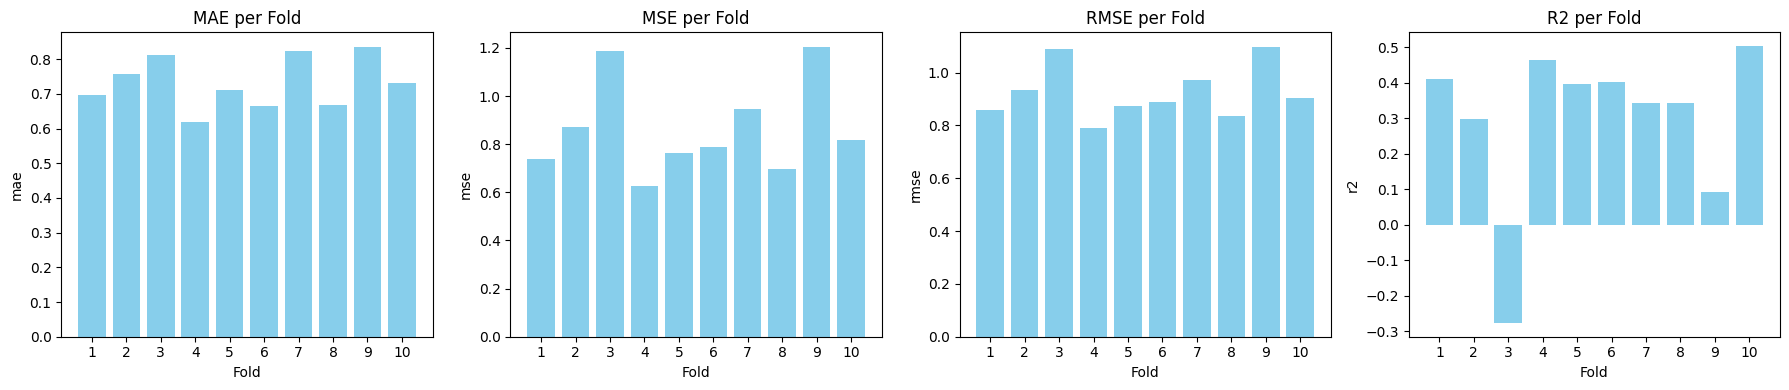

📊 Mean ± Std for Cross-Validation Metrics:


,mean,std
mae,0.7319,0.0740
mse,0.8639,0.1966
rmse,0.9244,0.1025
r2,0.2984,0.2309


In [34]:
# %%
import pandas as pd
import matplotlib.pyplot as plt

# Load summary
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df = pd.read_csv(cv_path)

# Choose metrics
task_metrics = (
    ['accuracy','precision','recall','f1_score','auc_roc']
    if task=="classification"
    else ['mae','mse','rmse','r2']
)

# Plot bar charts per fold
fig, axs = plt.subplots(1, len(task_metrics), figsize=(18, 4))
for i, metric in enumerate(task_metrics):
    axs[i].bar(cv_df['fold'], cv_df[metric], color='skyblue')
    axs[i].set_title(f"{metric.upper()} per Fold")
    axs[i].set_xlabel("Fold")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(cv_df['fold'])

plt.tight_layout()
plt.show()

# Display mean ± std
summary_stats = cv_df[task_metrics].agg(['mean','std']).T
print("📊 Mean ± Std for Cross-Validation Metrics:")
display(summary_stats.round(4))


## 8a: Ensemble Averaging from Cross-Validation Models

In [29]:
# Load test data
ensemble_preds = []
test_data = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

# Ensure model configuration matches
output_dim = num_classes if task == "classification" else 1

# Collect predictions from each fold model
for fold in range(10):
    model = GAT(in_channels=input_dim, hidden_channels=best_hidden_dim,
            out_channels=output_dim, heads=best_heads, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval()
    fold_outputs = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            fold_outputs.append(out.cpu())
    ensemble_preds.append(torch.cat(fold_outputs, dim=0))

# Average predictions across folds
avg_output = torch.stack(ensemble_preds).mean(dim=0)

# Prepare final predictions and true labels
if task == "classification":
    final_pred = avg_output.argmax(dim=1).numpy()
    true_labels = torch.cat([data.y for data in test_data]).numpy().astype(int)
else:
    final_pred = avg_output.squeeze().numpy()
    true_value = torch.cat([data.y for data in test_data]).numpy()

print(f"✅ Ensemble predictions ready: shape {final_pred.shape}")

✅ Ensemble predictions ready: shape (53,)


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/754690304.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(os.path.join(base_path,

## 8b: Ensemble Evaluation & Visualization


Ensemble: MAE=0.708, RMSE=0.898, R2=0.393


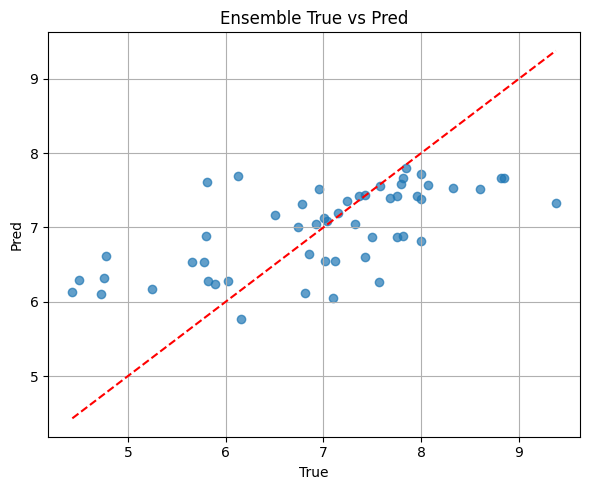

In [31]:


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
mae = mean_absolute_error(true_value, final_pred)
mse = mean_squared_error  (true_value, final_pred)
rmse= np.sqrt(mse)
r2  = r2_score           (true_value, final_pred)
print(f"Ensemble: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
plt.figure(figsize=(6,5)); plt.scatter(true_value,final_pred,alpha=0.7)
plt.plot([true_value.min(),true_value.max()],[true_value.min(),true_value.max()], 'r--'); plt.xlabel("True"); plt.ylabel("Pred"); plt.title("Ensemble True vs Pred"); plt.grid(True); plt.tight_layout(); plt.show()


## 9: Final Model Training on Combined Train+Val & Test Evaluation (Hold‑Out Test)

In [32]:
# %%
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge all train+val folds
all_data = []
for fold in range(10):
    all_data += torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    all_data += torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

# 2) Reserve a small val split for early stopping
tidx, vidx = train_test_split(
    list(range(len(all_data))),
    test_size=0.10,
    random_state=seed,
    shuffle=True
)
train_split = [all_data[i] for i in tidx]
val_split   = [all_data[i] for i in vidx]

train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_split,   batch_size=32)

# 3) Instantiate & train final model
model = GAT(in_channels=input_dim, hidden_channels=best_hidden_dim,
        out_channels=output_dim, heads=best_heads, dropout=best_dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)

best_val_loss = float('inf')
patience      = 0

for epoch in range(1, 300):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = (F.cross_entropy(out, batch.y.long())
                if task == "classification"
                else F.mse_loss(out.squeeze(), batch.y))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation for early stopping
    preds, targets = evaluate(model, val_loader)
    val_loss = (F.cross_entropy(preds, targets.long()).item()
                if task == "classification"
                else F.mse_loss(preds.squeeze(), targets).item())

    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience      = 0
        torch.save(model.state_dict(), os.path.join(results_dir, "final_model.pt"))
    else:
        patience += 1
        if patience >= 10:
            print("⏹️ Early stopping")
            break

# 4) Load best final model & evaluate on ORIGINAL TEST set
model.load_state_dict(torch.load(os.path.join(results_dir, "final_model.pt")))
test_data   = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

preds, targets = evaluate(model, test_loader)
pred_final     = (preds.argmax(dim=1).numpy() 
                  if task=="classification" 
                  else preds.squeeze().numpy())
true_final     = torch.cat([d.y for d in test_data]).numpy().astype(int if task=="classification" else float)

# 5) Compute final metrics
if task == "classification":
    from sklearn.metrics import (
        accuracy_score,
        precision_recall_fscore_support,
        roc_auc_score
    )
    acc       = accuracy_score(true_final, pred_final)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_final, pred_final, average="weighted", zero_division=0
    )
    probs     = F.softmax(preds, dim=1).cpu().numpy()
    auc       = roc_auc_score(
        label_binarize(true_final, classes=np.arange(num_classes)),
        probs, multi_class="ovr"
    )
    final_metrics = {
        "accuracy": acc, "precision": precision,
        "recall": recall, "f1_score": f1, "auc_roc": auc
    }
else:
    mae_f  = mean_absolute_error(true_final, pred_final)
    mse_f  = mean_squared_error(true_final, pred_final)
    rmse_f = np.sqrt(mse_f)
    r2_f   = r2_score(true_final, pred_final)
    final_metrics = {"mae": mae_f, "mse": mse_f, "rmse": rmse_f, "r2": r2_f}


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/1190220898.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data += torch.load(os.path.join(base_path

Epoch 001 | Train Loss: 4.5846 | Val Loss: 1.0536
Epoch 002 | Train Loss: 0.9920 | Val Loss: 1.0017
Epoch 003 | Train Loss: 0.9183 | Val Loss: 0.9493
Epoch 004 | Train Loss: 0.8839 | Val Loss: 0.9676
Epoch 005 | Train Loss: 0.8823 | Val Loss: 0.9280
Epoch 006 | Train Loss: 0.8642 | Val Loss: 0.9003
Epoch 007 | Train Loss: 0.8500 | Val Loss: 0.9040
Epoch 008 | Train Loss: 0.8207 | Val Loss: 0.9105
Epoch 009 | Train Loss: 0.8266 | Val Loss: 0.8999
Epoch 010 | Train Loss: 0.7894 | Val Loss: 0.8581
Epoch 011 | Train Loss: 0.7742 | Val Loss: 0.8827
Epoch 012 | Train Loss: 0.7600 | Val Loss: 0.8620
Epoch 013 | Train Loss: 0.7623 | Val Loss: 0.8436
Epoch 014 | Train Loss: 0.7311 | Val Loss: 0.8806
Epoch 015 | Train Loss: 0.7336 | Val Loss: 0.8125
Epoch 016 | Train Loss: 0.7271 | Val Loss: 0.8651
Epoch 017 | Train Loss: 0.7357 | Val Loss: 0.8177
Epoch 018 | Train Loss: 0.7044 | Val Loss: 0.8497
Epoch 019 | Train Loss: 0.7314 | Val Loss: 0.8619
Epoch 020 | Train Loss: 0.6970 | Val Loss: 0.9788


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/1190220898.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.joi

In [35]:
# Save final metrics to a CSV file
final_metrics_df = pd.DataFrame([final_metrics])
final_metrics_df.to_csv(os.path.join(results_dir, "final_metrics.csv"), index=False)

## 10. Generate plots and compare to ensemble

,metric,ensemble,final
0,mae,0.708458,0.683344
1,mse,0.806201,0.884268
2,rmse,0.897887,0.940355
3,r2,0.393255,0.334502


✅ Final model saved to GAT_results/regression_10fold/final_model.pt
✅ Ensemble plot saved to GAT_results/regression_10fold/ensemble_plot.png
✅ Final model plot saved to GAT_results/regression_10fold/final_model_plot.png


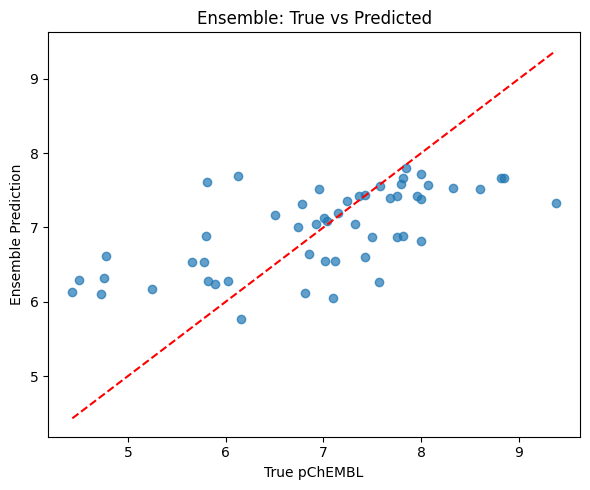

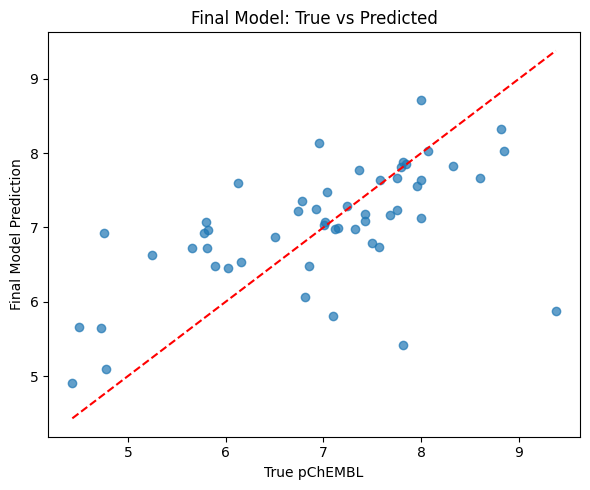

In [36]:
# Prepare ensemble metrics list
if task == "classification":
    ensemble_metrics = [acc, precision, recall, f1, auc]
else:
    ensemble_metrics = [mae, mse, rmse, r2]

# Create comparison DataFrame
comp = pd.DataFrame({
    "metric":   list(final_metrics.keys()),
    "ensemble": ensemble_metrics,
    "final":    list(final_metrics.values())
})
display(comp)


# 8) Save final model
model_path = os.path.join(results_dir, "final_model.pt")
torch.save(model.state_dict(), model_path)
print(f"✅ Final model saved to {model_path}")
#
ensemble_plot_path = os.path.join(results_dir, "ensemble_plot.png")
fig_ensemble, ax_ensemble = plt.subplots(figsize=(6, 5))
ax_ensemble.scatter(true_value, final_pred, alpha=0.7)
ax_ensemble.plot(
    [true_value.min(), true_value.max()],
    [true_value.min(), true_value.max()],
    'r--'
)
ax_ensemble.set_title("Ensemble: True vs Predicted")
ax_ensemble.set_xlabel("True pChEMBL")
ax_ensemble.set_ylabel("Ensemble Prediction")
plt.tight_layout()
fig_ensemble.savefig(ensemble_plot_path)
print(f"✅ Ensemble plot saved to {ensemble_plot_path}")

# Save final model plot
final_model_plot_path = os.path.join(results_dir, "final_model_plot.png")
fig_final, ax_final = plt.subplots(figsize=(6, 5))
ax_final.scatter(true_final, pred_final, alpha=0.7)
ax_final.plot(
    [true_final.min(), true_final.max()],
    [true_final.min(), true_final.max()],
    'r--'
)
ax_final.set_title("Final Model: True vs Predicted")
ax_final.set_xlabel("True pChEMBL")
ax_final.set_ylabel("Final Model Prediction")
plt.tight_layout()
fig_final.savefig(final_model_plot_path)
print(f"✅ Final model plot saved to {final_model_plot_path}")